In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time
from datetime import datetime, timedelta
import dateparser
import pytz

from binance.client import Client

from ta.volatility import BollingerBands
from ta.trend import ADXIndicator
from ta.momentum import RSIIndicator

import lightgbm as lgb
import optuna
from sklearn import metrics
from sklearn.model_selection import train_test_split
import gc

In [42]:

def date_to_milliseconds(date_str):
    """Convert UTC date to milliseconds

    If using offset strings add "UTC" to date string e.g. "now UTC", "11 hours ago UTC"

    See dateparse docs for formats http://dateparser.readthedocs.io/en/latest/

    :param date_str: date in readable format, i.e. "January 01, 2018", "11 hours ago UTC", "now UTC"
    :type date_str: str
    """
    # get epoch value in UTC
    epoch = datetime.utcfromtimestamp(0).replace(tzinfo=pytz.utc)
    # parse our date string
    d = dateparser.parse(date_str)
    # if the date is not timezone aware apply UTC timezone
    if d.tzinfo is None or d.tzinfo.utcoffset(d) is None:
        d = d.replace(tzinfo=pytz.utc)

    # return the difference in time
    return int((d - epoch).total_seconds() * 1000.0)


def interval_to_milliseconds(interval):
    """Convert a Binance interval string to milliseconds

    :param interval: Binance interval string 1m, 3m, 5m, 15m, 30m, 1h, 2h, 4h, 6h, 8h, 12h, 1d, 3d, 1w
    :type interval: str

    :return:
         None if unit not one of m, h, d or w
         None if string not in correct format
         int value of interval in milliseconds
    """
    ms = None
    seconds_per_unit = {
        "m": 60,
        "h": 60 * 60,
        "d": 24 * 60 * 60,
        "w": 7 * 24 * 60 * 60
    }

    unit = interval[-1]
    if unit in seconds_per_unit:
        try:
            ms = int(interval[:-1]) * seconds_per_unit[unit] * 1000
        except ValueError:
            pass
    return ms


def get_historical_klines(symbol, interval, start_str, end_str=None):
    """Get Historical Klines from Binance
    ...

    """
    client = Client("", "")
    output_data = []
    limit = 1000
    timeframe = interval_to_milliseconds(interval)
    start_ts = date_to_milliseconds(start_str)
    end_ts = None
    if end_str:
        end_ts = date_to_milliseconds(end_str)

    symbol_existed = False
    while True:
        temp_data = client.futures_historical_klines(
            symbol=symbol,
            interval=interval,
            limit=limit,
            start_str=start_ts,
            end_str=end_ts
        )

        if not temp_data:  # check if the list is empty
            break  # if so, break the loop

        if not symbol_existed and len(temp_data):
            symbol_existed = True

        if symbol_existed:
            output_data += temp_data
            start_ts = temp_data[len(temp_data) - 1][0] + timeframe
        else:
            start_ts += timeframe

        if len(temp_data) < limit:
            break

        if symbol_existed and len(output_data) % (3*limit) == 0:  # adjust the sleep condition
            time.sleep(1)
            
    return output_data
    
def plot_klines(klines, symbol):
    """Plot the closing prices from klines data.

    :param klines: list of OHLCV values
    :param symbol: Name of symbol pair e.g BNBBTC
    """

    # Convert the data to DataFrame
    df = pd.DataFrame(klines, columns=['Open time', 'Close'])

    # Convert timestamps to datetime objects
    df['Open time'] = pd.to_datetime(df['Open time'], unit='ms')

    # Convert 'Close' column to float
    df['Close'] = df['Close'].astype(float)

    # Plot the close prices
    plt.figure(figsize=(14,7))
    plt.plot(df['Open time'], df['Close'])
    plt.title(f'{symbol} price')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.show()




In [51]:

symbol = "BTCUSDT"
start = "1 Jan, 2022"
end = "1 Feb, 2022"
interval = Client.KLINE_INTERVAL_30MINUTE

klines = get_historical_klines(symbol, interval, start, end)

# choose open time (0) and close price (4)
klines = np.array(klines)
klines = klines[:, [0, 4]]

# Visualize data
plot_klines(klines[:, [0, 4]], symbol)

NameError: name 'Client' is not defined

In [ ]:

# Initialize Binance client
client = Client("", "")

# Set symbol and intervals
symbol = "BTCUSDT"
intervals = ['1m', '5m', '15m', '1h', '4h']

# Set windows for each interval
windows = {
    '1m': 12,
    '5m': 12,
    '15m': 12,
    '1h': 12,
    '4h': 6
}


# Fetch klines for each interval and calculate indicators
dfs = []
for interval in intervals:
    klines = client.get_historical_klines(symbol, interval, "1 Jan, 2017", "1 Jul, 2023")

    # Create DataFrame
    df = pd.DataFrame(klines, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'trades', 'taker_buy_base', 'taker_buy_quote', 'ignore'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

    # Set data types
    df['open'] = df['open'].astype(float)
    df['high'] = df['high'].astype(float)
    df['low'] = df['low'].astype(float)
    df['close'] = df['close'].astype(float)
    df['volume'] = df['volume'].astype(float)

    # Bollinger Bands
    boll = BollingerBands(df['close'], window=windows[interval])
    df['boll_mavg'] = boll.bollinger_mavg()
    df['boll_hband'] = boll.bollinger_hband()
    df['boll_lband'] = boll.bollinger_lband()
    df['boll_bandwidth'] = (boll.bollinger_hband() - boll.bollinger_lband()) / boll.bollinger_mavg()

    # RSI
    rsi = RSIIndicator(df['close'], window=windows[interval])
    for i in range(windows[interval]):
        df[f'{interval}_rsi_{i+1}'] = rsi.rsi().shift(i)

    # ADX
    adx = ADXIndicator(df['high'], df['low'], df['close'], window=windows[interval])
    for i in range(windows[interval]):
        df[f'{interval}_adx_{i+1}'] = adx.adx().shift(i)

    # Calculate close price change rate
    df[f'{interval}_close_change_rate'] = df['close'].pct_change()
    for i in range(windows[interval]):
        df[f'{interval}_close_change_rate_{i+1}'] = df[f'{interval}_close_change_rate'].shift(i)
        df[f'{interval}_boll_bandwidth_{i+1}'] = df['boll_bandwidth'].shift(i)


    df[f'{interval}_close'] = df['close']

    # Add scaled close prices
    base_close = df['close'].shift(windows[interval])
    for i in range(windows[interval]):
        df[f'{interval}_close_scale_{i+1}'] = df['close'].shift(i).div(base_close).where(base_close != 0, 1)


    # Add scaled volume
    base_volume = df['volume'].shift(windows[interval])
    for i in range(windows[interval]):
        df[f'{interval}_volume_scale_{i+1}'] = df['volume'].shift(i).div(base_volume).where(base_volume != 0, 1)

    # Resampling to 1 minute intervals and forward fill the missing values
    df.set_index('timestamp', inplace=True)
    df = df.resample('1T').ffill()

        

    # Select only the required columns
    cols = [f'{interval}_rsi_{i+1}' for i in range(windows[interval])] + \
           [f'{interval}_adx_{i+1}' for i in range(windows[interval])] + \
           [f'{interval}_close_change_rate_{i+1}' for i in range(windows[interval])] + \
           [f'{interval}_boll_bandwidth_{i+1}' for i in range(windows[interval])] + \
           [f'{interval}_close_scale_{i+1}' for i in range(windows[interval])] + \
           [f'{interval}_volume_scale_{i+1}' for i in range(windows[interval])] + \
           [f'{interval}_close']
    df = df[cols]

    # Append the df to dfs list
    dfs.append(df)


# Combine all data
df_merged = pd.concat(dfs, axis=1)

# Drop NA values
df_merged.dropna(inplace=True)

# Drop the first 24 hours of data
df_merged = df_merged[df_merged.index > df_merged.index[0] + pd.Timedelta(hours=24)]



print(df_merged)


c:\Users\sangwon\anaconda3\envs\baynance\Lib\site-packages\ta\trend.py:780: RuntimeWarning: invalid value encountered in scalar divide
  dip[idx] = 100 * (self._dip[idx] / value)
c:\Users\sangwon\anaconda3\envs\baynance\Lib\site-packages\ta\trend.py:785: RuntimeWarning: invalid value encountered in scalar divide
  din[idx] = 100 * (self._din[idx] / value)
c:\Users\sangwon\anaconda3\envs\baynance\Lib\site-packages\ta\trend.py:780: RuntimeWarning: invalid value encountered in scalar divide
  dip[idx] = 100 * (self._dip[idx] / value)
c:\Users\sangwon\anaconda3\envs\baynance\Lib\site-packages\ta\trend.py:785: RuntimeWarning: invalid value encountered in scalar divide
  din[idx] = 100 * (self._din[idx] / value)
c:\Users\sangwon\anaconda3\envs\baynance\Lib\site-packages\ta\trend.py:780: RuntimeWarning: invalid value encountered in scalar divide
  dip[idx] = 100 * (self._dip[idx] / value)
c:\Users\sangwon\anaconda3\envs\baynance\Lib\site-packages\ta\trend.py:785: RuntimeWarning: invalid value

                      1m_rsi_1   1m_rsi_2   1m_rsi_3   1m_rsi_4   1m_rsi_5  \
timestamp                                                                    
2017-08-19 20:01:00  76.032884  76.032884   5.318972   5.318972   5.318972   
2017-08-19 20:02:00  20.951037  76.032884  76.032884   5.318972   5.318972   
2017-08-19 20:03:00  56.002592  20.951037  76.032884  76.032884   5.318972   
2017-08-19 20:04:00  56.002592  56.002592  20.951037  76.032884  76.032884   
2017-08-19 20:05:00  56.002592  56.002592  56.002592  20.951037  76.032884   
...                        ...        ...        ...        ...        ...   
2023-06-30 23:56:00  38.621278  43.425529  48.194863  48.601733  47.552793   
2023-06-30 23:57:00  41.719590  38.621278  43.425529  48.194863  48.601733   
2023-06-30 23:58:00  38.767187  41.719590  38.621278  43.425529  48.194863   
2023-06-30 23:59:00  40.532930  38.767187  41.719590  38.621278  43.425529   
2023-07-01 00:00:00  46.816859  40.532930  38.767187  41.719590 

In [ ]:
df_merged.to_pickle('../database/raw/merged_1Jan2017_1Jul2023.pkl') # Save the merged DataFrame to pickle

In [ ]:
df_1m = dfs[0] # Assuming that dfs[0] contains '1m' interval data
df_1m['1m_close'] = df_1m['1m_close'].astype(float) # Convert 'close' to float

def count_pivots(x):
    # Identify pivot points
    pivots = np.where(((x.shift(-1) > x) & (x.shift(1) > x)) |
                      ((x.shift(-1) < x) & (x.shift(1) < x)), x, np.nan)

    # Forward fill the pivot points
    pivots = pd.Series(pivots).ffill()

    # Calculate the price change
    changes = pivots.pct_change()

    # Count where the change is greater than 2%
    return (changes.abs() >= 0.02).sum()

# Apply the function over a rolling window
df_1m['target'] = df_1m['1m_close'].rolling('120T').apply(count_pivots)
df_merged = df_merged.join(df_1m['target'])  # Join the target data to the merged DataFrame

# Drop close price columns except for 1m
for interval in intervals:
    df_merged.drop(f'{interval}_close', axis=1, inplace=True)


In [ ]:
df_merged.to_pickle('../database/processed/120T_processed_1Jan2017_1Jul2023.pkl') # Save the merged DataFrame to pickle

In [39]:
df_merged = pd.read_pickle('../database/processed/120T_processed_1Jan2017_1Jul2023.pkl') # Load the merged DataFrame from pickle

In [ ]:
df_merged.shape

(3083280, 325)

In [ ]:
df_merged.loc[df_merged['target'] > 0, 'target'] = 1

In [ ]:
df_merged.value_counts('target')

target
0.0    2966182
1.0     117098
Name: count, dtype: int64

In [ ]:
train,test = train_test_split(df_merged,test_size = 0.3, stratify=df_merged['target'])

In [7]:
del df_merged
gc.collect()

512

In [8]:
train.to_pickle('../database/processed/120T_processed_train_1Jan2017_1Jul2023.pkl') # Save the merged DataFrame to pickle

In [7]:
test.to_pickle('../database/processed/120T_processed_test_1Jan2017_1Jul2023.pkl') # Save the merged DataFrame to pickle

In [45]:
for idx, row in example.iterrows():
    # Select 30 minutes of data starting from the current index
    data = df_merged.loc[idx : idx + pd.Timedelta(minutes=30), '1m_close']

    # Convert the data to the format required by the plot function
    data = data.reset_index().rename(columns={'timestamp': 'Open time', '1m_close': 'Close'})

    # Convert the data types
    data['Open time'] = data['Open time'].astype('int64') // 10**6
    data['Close'] = data['Close'].astype(float)

    # Plot the data
    plot_klines(data.values.tolist(), symbol)


KeyError: '1m_close'

In [2]:
train = pd.read_pickle('../database/processed/120T_processed_train_1Jan2017_1Jul2023.pkl')

In [3]:
# 먼저 전체 데이터셋을 훈련 데이터와 테스트 데이터로 분리합니다.
X_train, X_test, y_train, y_test = train_test_split(train.iloc[:,:-1], train['target'], test_size=0.2, random_state=42)

# 다음으로 훈련 데이터를 다시 훈련 데이터와 검증 데이터로 분리합니다.
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2


In [4]:
del train
gc.collect()

0

In [5]:
dtrain = lgb.Dataset(X_train, label=y_train )
dval = lgb.Dataset(X_val, label=y_val,free_raw_data=False ).construct()
dtest = lgb.Dataset(X_test, label=y_test,free_raw_data=False).construct()

In [6]:
# aux functions for binary classification evaluation
def calc_threshold_at_fpr(y_true: np.ndarray, y_score: np.ndarray, fpr: float):
    temp_df = pd.DataFrame(
        {'y_true': y_true,
         'y_score': y_score,
         })
    temp_df = temp_df.sort_values(by='y_score', ascending=False, ignore_index=True)
    temp_df['pseudo_fpr'] = (temp_df['y_true']
                             .apply(lambda x: 1 if x == 0 else 0)
                             .cumsum()
                             .divide(sum(y_true == 0)))

    critical_threshold = float((
        temp_df
        .loc[temp_df['pseudo_fpr'] < fpr, 'y_score']
        .iloc[-1]))

    return critical_threshold

def predict_at_fpr(y_true: np.ndarray, y_score: np.ndarray, fpr: float):
    threshold_at_fpr = calc_threshold_at_fpr(
        y_true=y_true, y_score=y_score, fpr=fpr)

    return (y_score > threshold_at_fpr).astype(int)

In [7]:
NON_TUNED_PARAMS = dict(
    objective='binary',
    verbosity='-1',
    enable_bundle=True,
    feature_pre_filter=False,  # to enable min_child_samples exploration
    device = 'gpu',
    gpu_platform_id = 1,
    gpu_device_id = 0 
)

In [8]:
def _objective(trial, dtrain, dval, dtest, early_stopping, optimization_logs):
    params = {
        # 'feature_pre_filter': False,  # always disable pre-filter
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'goss']),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256, log=True),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 2, 256, log=True),
        'bagging_freq': trial.suggest_categorical('bagging_freq', [0, 1]),
        'pos_bagging_fraction': trial.suggest_float('pos_bagging_fraction', 0.1, 1),
        'neg_bagging_fraction': trial.suggest_float('neg_bagging_fraction', 0.1, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.00001, 0.1, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.00001, 0.1, log=True),
    }

    model = lgb.train(
        {**NON_TUNED_PARAMS, **params},
        dtrain,
        num_boost_round=(
            4000 if early_stopping
            else trial.suggest_int('num_boost_rounds', 10, 4000)
        ),
        valid_sets=dval if early_stopping else None,
        callbacks=(
            [lgb.early_stopping(stopping_rounds=100, verbose=False)] if early_stopping
            else None
        ),
    )

    y_val = dval.get_label()
    y_val_score = model.predict(dval.get_data())
    y_test = dtest.get_label()  # test eval for experimental purposes
    y_test_score = model.predict(dtest.get_data())

    artifacts = {
        # 'y_score': y_score,
        'num_boosting_rounds': model.num_trees(),
        'log_loss': metrics.log_loss(y_true=y_val, y_pred=y_val_score),
        'recall_at_fpr': metrics.recall_score(y_true=y_val, y_pred=predict_at_fpr(y_val, y_val_score, fpr=0.05)),
        'test_log_loss': metrics.log_loss(y_true=y_test, y_pred=y_test_score),
        'test_recall_at_fpr': metrics.recall_score(y_true=y_test, y_pred=predict_at_fpr(y_test, y_test_score, fpr=0.05)),
    }
    optimization_logs.append(artifacts)

    return artifacts['log_loss']

In [9]:
ES_OPTIMIZATION_LOGS = []  # keep records
es_study = optuna.create_study(
    sampler=optuna.samplers.RandomSampler(seed=42),
    directions=['minimize'],  # ignored (random sampling)
)
es_study.optimize(
    lambda trial: _objective(
        trial=trial,
        dtrain=dtrain, dval=dval, dtest=dtest,
        early_stopping=True,
        optimization_logs=ES_OPTIMIZATION_LOGS),
    n_trials=100,
    catch=(Exception,)  # Add this line
)

[I 2023-07-13 18:56:01,608] A new study created in memory with name: no-name-82a31c66-f4c5-4a72-8b9c-4a3c15396786
[I 2023-07-13 19:12:13,988] Trial 0 finished with value: 0.0034457135374099997 and parameters: {'boosting_type': 'goss', 'learning_rate': 0.17524101118128144, 'num_leaves': 33, 'max_depth': 3, 'min_child_samples': 3, 'bagging_freq': 1, 'pos_bagging_fraction': 0.6410035105688879, 'neg_bagging_fraction': 0.737265320016441, 'reg_alpha': 1.2087541473056957e-05, 'reg_lambda': 0.07579479953348005}. Best is trial 0 with value: 0.0034457135374099997.
[I 2023-07-13 19:15:55,665] Trial 1 finished with value: 0.03337482088932154 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.020366442026830918, 'num_leaves': 4, 'max_depth': 4, 'min_child_samples': 22, 'bagging_freq': 0, 'pos_bagging_fraction': 0.6506676052501416, 'neg_bagging_fraction': 0.22554447458683766, 'reg_alpha': 0.00014742753159914678, 'reg_lambda': 0.0002920433847181409}. Best is trial 0 with value: 0.0034457135

In [10]:
es_results = pd.concat([es_study.trials_dataframe(), pd.DataFrame(ES_OPTIMIZATION_LOGS)], axis=1)
es_results[f'best_log_loss'] = es_results['log_loss'].expanding().min()
es_results[f'best_recall_at_fpr'] = es_results['recall_at_fpr'].expanding().max()
es_results[f'test_best_log_loss'] = es_results['test_log_loss'].expanding().min()
es_results[f'test_best_recall_at_fpr'] = es_results['test_recall_at_fpr'].expanding().max()
es_results

,number,value,datetime_start,datetime_complete,duration,params_bagging_freq,params_boosting_type,params_learning_rate,params_max_depth,params_min_child_samples,...,state,num_boosting_rounds,log_loss,recall_at_fpr,test_log_loss,test_recall_at_fpr,best_log_loss,best_recall_at_fpr,test_best_log_loss,test_best_recall_at_fpr
0,0,0.003446,2023-07-13 18:56:01.610309,2023-07-13 19:12:13.985614,0 days 00:16:12.375305,1,goss,0.175241,3,3,...,COMPLETE,4000.0,0.003446,0.999449,0.003247,0.999695,0.003446,0.999449,0.003247,0.999695
1,1,0.033375,2023-07-13 19:12:14.010616,2023-07-13 19:15:55.664612,0 days 00:03:41.653996,0,gbdt,0.020366,4,22,...,COMPLETE,4000.0,0.033375,0.990262,0.033733,0.988603,0.003446,0.999449,0.003247,0.999695
2,2,0.006497,2023-07-13 19:15:55.666617,2023-07-13 19:31:00.298698,0 days 00:15:04.632081,0,goss,0.021839,7,2,...,COMPLETE,4000.0,0.006497,0.999571,0.006616,0.999817,0.003446,0.999571,0.003247,0.999817
3,3,0.036338,2023-07-13 19:31:00.299723,2023-07-13 19:31:24.787073,0 days 00:00:24.487350,1,gbdt,0.145376,3,19,...,COMPLETE,253.0,0.036338,0.985607,0.036864,0.982813,0.003446,0.999571,0.003247,0.999817
4,4,0.046645,2023-07-13 19:31:24.790073,2023-07-13 19:31:46.947071,0 days 00:00:22.156998,1,gbdt,0.443910,10,149,...,COMPLETE,30.0,0.046645,0.980891,0.049408,0.982387,0.003446,0.999571,0.003247,0.999817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,NaN,2023-07-14 04:05:06.957793,2023-07-14 04:06:06.475791,0 days 00:00:59.517998,0,gbdt,0.141883,4,137,...,FAIL,NaN,NaN,NaN,NaN,NaN,0.002315,0.999939,0.002308,0.999939
96,96,0.031179,2023-07-14 04:06:06.479791,2023-07-14 04:06:44.081019,0 days 00:00:37.601228,0,gbdt,0.112461,3,139,...,COMPLETE,NaN,NaN,NaN,NaN,NaN,0.002315,0.999939,0.002308,0.999939
97,97,0.052592,2023-07-14 04:06:44.082060,2023-07-14 04:07:27.885284,0 days 00:00:43.803224,1,goss,0.259281,2,7,...,COMPLETE,NaN,NaN,NaN,NaN,NaN,0.002315,0.999939,0.002308,0.999939
98,98,0.059997,2023-07-14 04:07:27.886211,2023-07-14 04:07:44.765293,0 days 00:00:16.879082,1,gbdt,0.196320,10,9,...,COMPLETE,NaN,NaN,NaN,NaN,NaN,0.002315,0.999939,0.002308,0.999939


In [11]:
es_results[es_results['number']==88]

,number,value,datetime_start,datetime_complete,duration,params_bagging_freq,params_boosting_type,params_learning_rate,params_max_depth,params_min_child_samples,...,state,num_boosting_rounds,log_loss,recall_at_fpr,test_log_loss,test_recall_at_fpr,best_log_loss,best_recall_at_fpr,test_best_log_loss,test_best_recall_at_fpr
88,88,0.002315,2023-07-14 03:29:28.074987,2023-07-14 03:35:01.866039,0 days 00:05:33.791052,0,gbdt,0.065357,9,236,...,COMPLETE,NaN,NaN,NaN,NaN,NaN,0.002315,0.999939,0.002308,0.999939


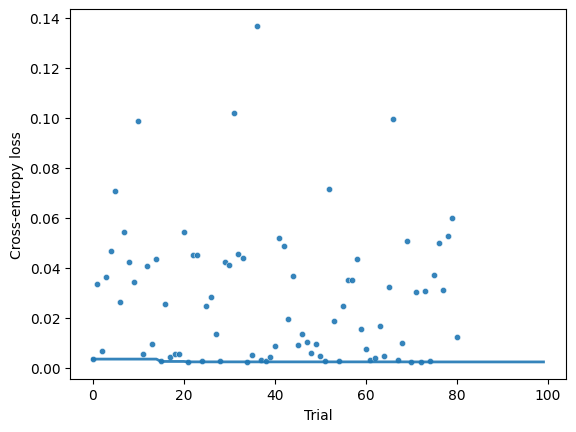

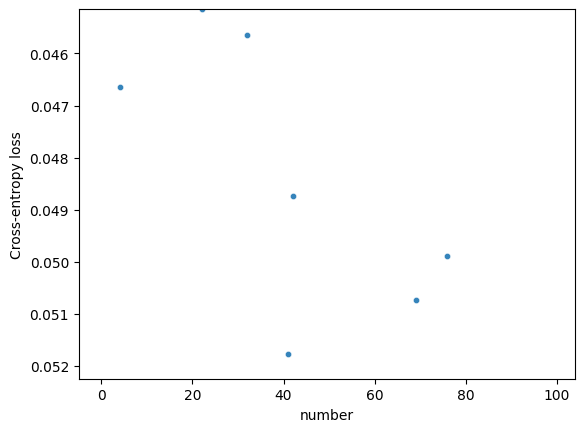

In [12]:
sns.lineplot(
    data=es_results,
    x='number', y='best_log_loss',
    linewidth=2, alpha=0.9, legend=None,
)
sns.scatterplot(
    data=es_results,
    x='number', y='log_loss',
    s=20, alpha=0.9,
)
plt.xlabel('Trial')
plt.ylabel('Cross-entropy loss')
# plt.legend(title='Early stopping')
plt.show()

sns.lineplot(
    data=es_results,
    x='number', y='best_log_loss',
    linewidth=2, alpha=0.9, legend=None,
)
sns.scatterplot(
    data=es_results,
    x='number', y='log_loss',
    s=20, alpha=0.9,
)
plt.ylim(0.05225, es_results['log_loss'].quantile(0.8))
plt.xlabel('number')
plt.ylabel('Cross-entropy loss')
# plt.legend(title='Early stopping')
plt.show()

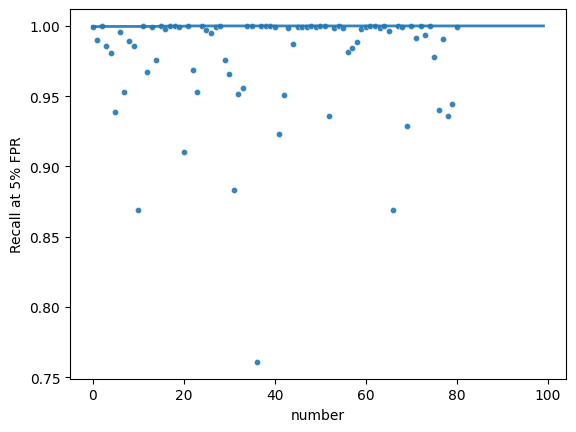

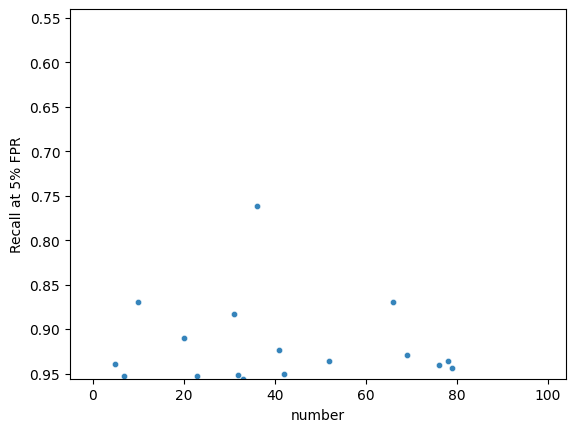

In [13]:
sns.lineplot(
    data=es_results,
    x='number', y='best_recall_at_fpr',
    linewidth=2, alpha=0.9, legend=None,
)
sns.scatterplot(
    data=es_results, 
    x='number', y='recall_at_fpr',
    s=20, alpha=0.9,
)
plt.xlabel('number')
plt.ylabel('Recall at 5% FPR')
plt.show()

sns.lineplot(
    data=es_results,
    x='number', y='best_recall_at_fpr',
    linewidth=2, alpha=0.9, legend=None,
)
sns.scatterplot(
    data=es_results,
    x='number', y='recall_at_fpr',
    s=20, alpha=0.9,
)
plt.ylim(es_results['recall_at_fpr'].quantile(0.2), 0.54)
plt.xlabel('number')
plt.ylabel('Recall at 5% FPR')
plt.show()

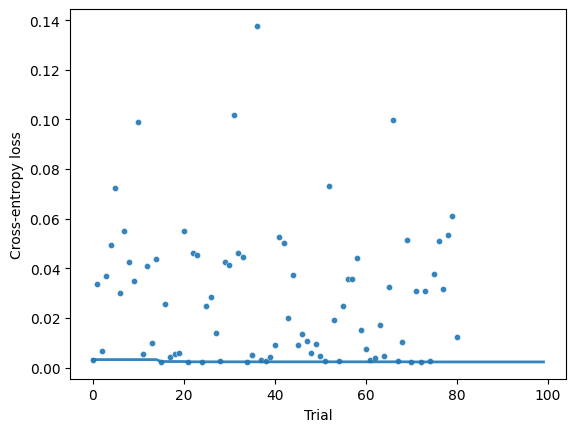

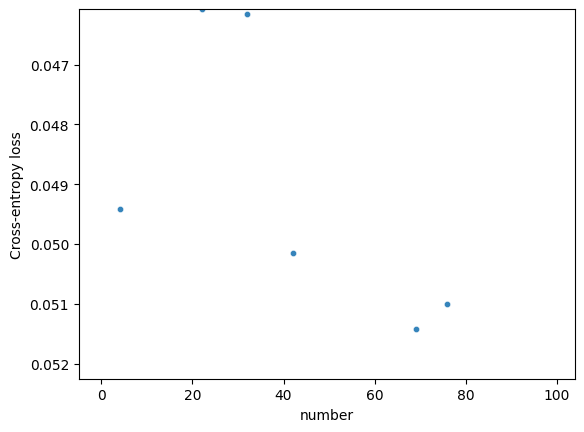

In [14]:
sns.lineplot(
    data=es_results,
    x='number', y='test_best_log_loss',
    linewidth=2, alpha=0.9, legend=None,
)
sns.scatterplot(
    data=es_results,
    x='number', y='test_log_loss',
    s=20, alpha=0.9,
)
plt.xlabel('Trial')
plt.ylabel('Cross-entropy loss')
# plt.legend(title='Early stopping')
plt.show()

sns.lineplot(
    data=es_results,
    x='number', y='test_best_log_loss',
    linewidth=2, alpha=0.9, legend=None,
)
sns.scatterplot(
    data=es_results,
    x='number', y='test_log_loss',
    s=20, alpha=0.9,
)
plt.ylim(0.05225, es_results['test_log_loss'].quantile(0.8))
plt.xlabel('number')
plt.ylabel('Cross-entropy loss')
# plt.legend(title='Early stopping')
plt.show()

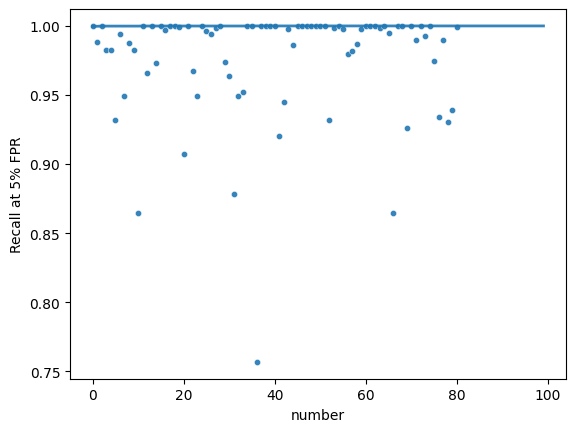

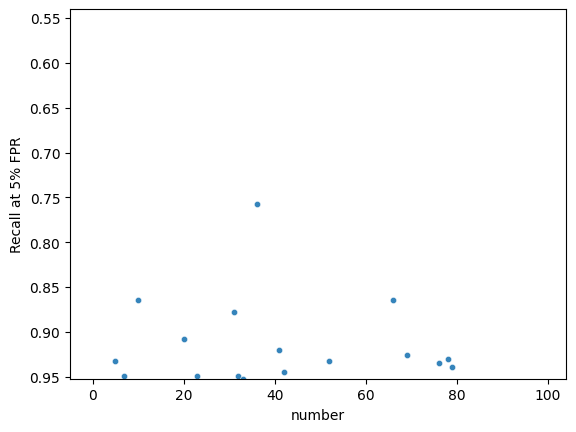

In [16]:
sns.lineplot(
    data=es_results,
    x='number', y='test_best_recall_at_fpr',
    linewidth=2, alpha=0.9, legend=None,
)
sns.scatterplot(
    data=es_results, 
    x='number', y='test_recall_at_fpr',
    s=20, alpha=0.9,
)
plt.xlabel('number')
plt.ylabel('Recall at 5% FPR')
plt.show()

sns.lineplot(
    data=es_results,
    x='number', y='test_best_recall_at_fpr',
    linewidth=2, alpha=0.9, legend=None,
)
sns.scatterplot(
    data=es_results,
    x='number', y='test_recall_at_fpr',
    s=20, alpha=0.9,
)
plt.ylim(es_results['test_recall_at_fpr'].quantile(0.2), 0.54)
plt.xlabel('number')
plt.ylabel('Recall at 5% FPR')
plt.show()

In [19]:
best_params = es_study.best_params
print(best_params)

# Combine the best tuned parameters with the non-tuned parameters
all_params = {**NON_TUNED_PARAMS, **best_params}
print(all_params)


{'boosting_type': 'gbdt', 'learning_rate': 0.06535732740681059, 'num_leaves': 38, 'max_depth': 9, 'min_child_samples': 236, 'bagging_freq': 0, 'pos_bagging_fraction': 0.4792213020493632, 'neg_bagging_fraction': 0.7638240714300023, 'reg_alpha': 9.017965781950582e-05, 'reg_lambda': 2.766282010813135e-05}
{'objective': 'binary', 'verbosity': '-1', 'enable_bundle': True, 'feature_pre_filter': False, 'device': 'gpu', 'gpu_platform_id': 1, 'gpu_device_id': 0, 'boosting_type': 'gbdt', 'learning_rate': 0.06535732740681059, 'num_leaves': 38, 'max_depth': 9, 'min_child_samples': 236, 'bagging_freq': 0, 'pos_bagging_fraction': 0.4792213020493632, 'neg_bagging_fraction': 0.7638240714300023, 'reg_alpha': 9.017965781950582e-05, 'reg_lambda': 2.766282010813135e-05}


In [20]:

best_model = lgb.train(all_params, dtrain)


In [21]:
best_model.save_model('model.txt', num_iteration=best_model.best_iteration)

In [22]:
test = pd.read_pickle('../database/processed/120T_processed_test_1Jan2017_1Jul2023.pkl')

In [23]:
dtest = lgb.Dataset(
    data=test.iloc[:,:-1],
    label=test['target'],
)
    

In [24]:
y_pred = best_model.predict(dtest.data)
y_test = dtest.label
test_log_loss = metrics.log_loss(y_true=y_test, y_pred=y_pred),
test_recall_at_fpr = metrics.recall_score(y_true=y_test, y_pred=predict_at_fpr(y_test, y_pred, fpr=0.05)),

In [35]:
threshold = calc_threshold_at_fpr(y_test, y_pred, fpr=0.05)
threshold

0.04850388229774374

In [25]:
test_log_loss, test_recall_at_fpr

((0.03232909705468841,), (0.9894104585954624,))

In [26]:
test_roc_auc = metrics.roc_auc_score(y_true=y_test, y_score=y_pred)
test_roc_auc

0.9962152617962523

In [29]:
y_pred

array([0.00049876, 0.00043117, 0.00014628, ..., 0.00058754, 0.00553721,
       0.00790018])

In [37]:
from sklearn.metrics import confusion_matrix, f1_score,accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.preprocessing import Binarizer

def get_eval_by_threshold(y_test , pred_proba_c1, thresholds):
    # thresholds list객체내의 값을 차례로 iteration하면서 Evaluation 수행.
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1) 
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값:',custom_threshold)
        get_clf_eval(y_test , custom_predict, pred_proba_c1)

def get_clf_eval(y_test , pred, pred_proba):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # f1 score print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

# make a list of thresholds to try
thresholds = np.arange(0.1, 0.5, 0.01)
get_eval_by_threshold(dtest.label, y_pred.reshape(-1,1), thresholds)

임곗값: 0.1
오차 행렬
[[863498  26357]
 [   880  34249]]
정확도: 0.9706, 정밀도: 0.5651, 재현율: 0.9749, F1: 0.7155, AUC:0.9962
임곗값: 0.11
오차 행렬
[[865488  24367]
 [   974  34155]]
정확도: 0.9726, 정밀도: 0.5836, 재현율: 0.9723, F1: 0.7294, AUC:0.9962
임곗값: 0.12
오차 행렬
[[867232  22623]
 [  1101  34028]]
정확도: 0.9744, 정밀도: 0.6007, 재현율: 0.9687, F1: 0.7415, AUC:0.9962
임곗값: 0.13
오차 행렬
[[868716  21139]
 [  1215  33914]]
정확도: 0.9758, 정밀도: 0.6160, 재현율: 0.9654, F1: 0.7521, AUC:0.9962
임곗값: 0.13999999999999999
오차 행렬
[[870072  19783]
 [  1319  33810]]
정확도: 0.9772, 정밀도: 0.6309, 재현율: 0.9625, F1: 0.7622, AUC:0.9962
임곗값: 0.14999999999999997
오차 행렬
[[871417  18438]
 [  1458  33671]]
정확도: 0.9785, 정밀도: 0.6462, 재현율: 0.9585, F1: 0.7719, AUC:0.9962
임곗값: 0.15999999999999998
오차 행렬
[[872506  17349]
 [  1587  33542]]
정확도: 0.9795, 정밀도: 0.6591, 재현율: 0.9548, F1: 0.7799, AUC:0.9962
임곗값: 0.16999999999999998
오차 행렬
[[873477  16378]
 [  1737  33392]]
정확도: 0.9804, 정밀도: 0.6709, 재현율: 0.9506, F1: 0.7866, AUC:0.9962
임곗값: 0.17999999999999997
오차 행렬
[[8743